In [1]:
#libraries
import datetime as dt
import xarray as xr
import numpy as np
import fsspec
import s3fs
import os.path
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from osgeo import osr
from osgeo import gdal
import time as t
import datetime
#from mpl_toolkits.basemap import Basemap #first have to conda install basemap
import cartopy
import cartopy.crs as ccrs

# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 



In [2]:
#Load in zarr data
#%%time

file_location = 's3://ohw-bucket/goes_zarr'

ikey = fsspec.get_mapper(file_location,anon=False)

ds = xr.open_zarr(ikey) #,consolidated=True)

ds

,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,31.07 GB,117.68 MB
Shape,"(264, 5424, 5424)","(1, 5424, 5424)"
Count,265 Tasks,264 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


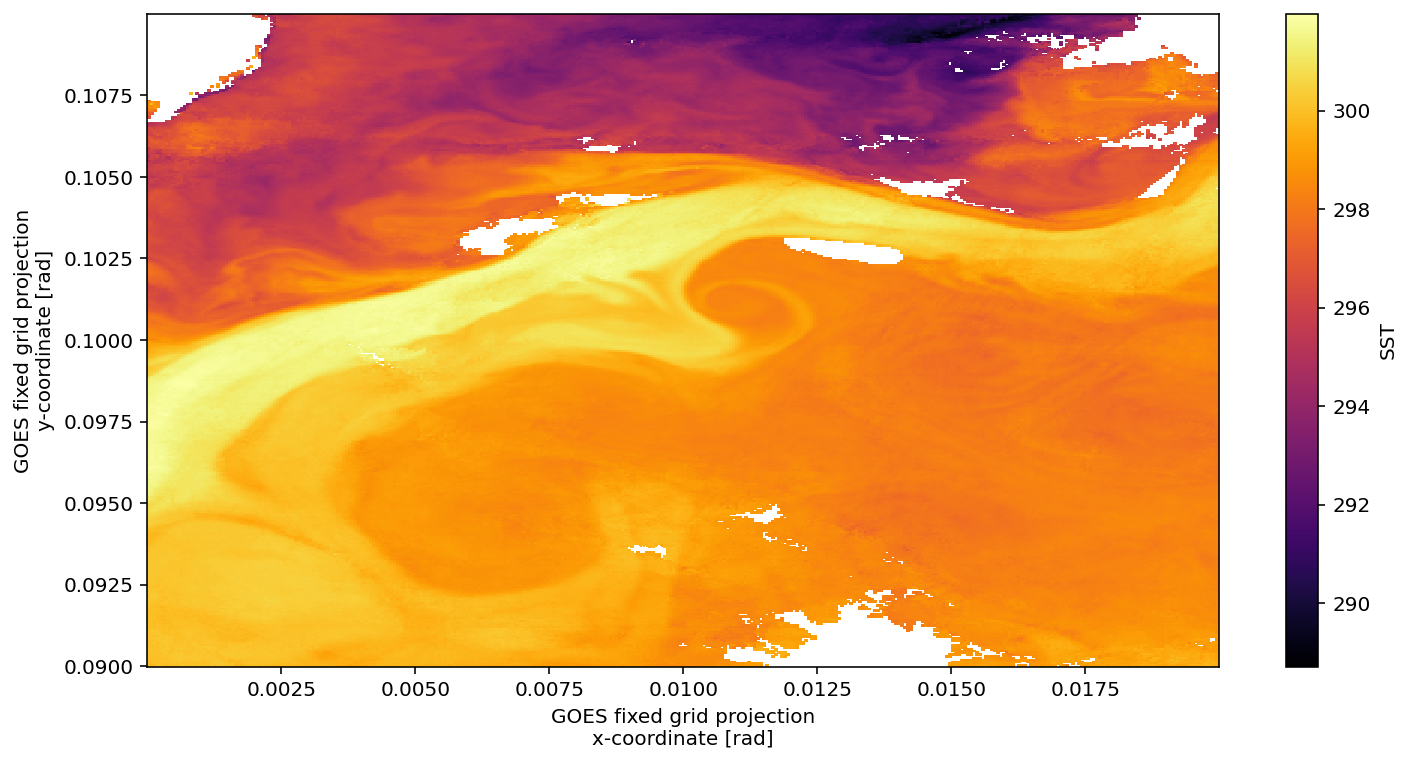

In [3]:
#Create basic plot (w/o sensible coords)
ds_subset = ds.isel(time=slice(0,24))
gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
#gs_subset = ds_subset
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
mean_SST.plot(cmap='inferno')

In [4]:
#Convert x and y to coordinates
#Algorithm based off https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
#Note output lat and lon are 2D with dimentions [lat, lon] 

# GOES-R projection info and retrieving relevant constants
proj_info = ds.variables['goes_imager_projection']
#print(proj_info)
lon_origin = proj_info.attrs['longitude_of_projection_origin'][0]
H = proj_info.attrs['perspective_point_height'][0]+proj_info.attrs['semi_major_axis'][0]
r_eq = proj_info.attrs['semi_major_axis'][0]
r_pol = proj_info.attrs['semi_minor_axis'][0]

# Data info
lat_rad_1d = ds.variables['x'][:]
lon_rad_1d = ds.variables['y'][:]

# close file when finished
#g16nc.close()
#g16nc = None

# create meshgrid filled with radian angles
lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

# lat/lon calc routine from satellite radian angle vectors

lambda_0 = (lon_origin*np.pi)/180.0

a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

#print(lat[0,0], lat[100,0])

#Change coordinates in xarray? 
#ds.coords['x'] = lon
#ds.coords['y'] = lat

# print test coordinates
print('{} N, {} W'.format(lat[318,1849],abs(lon[318,1849])))

<ipython-input-4-516e2c334284>:30: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


56.290740966796875 N, 107.58478546142578 W


-156.27083 6.2708173
-81.15669 81.15669


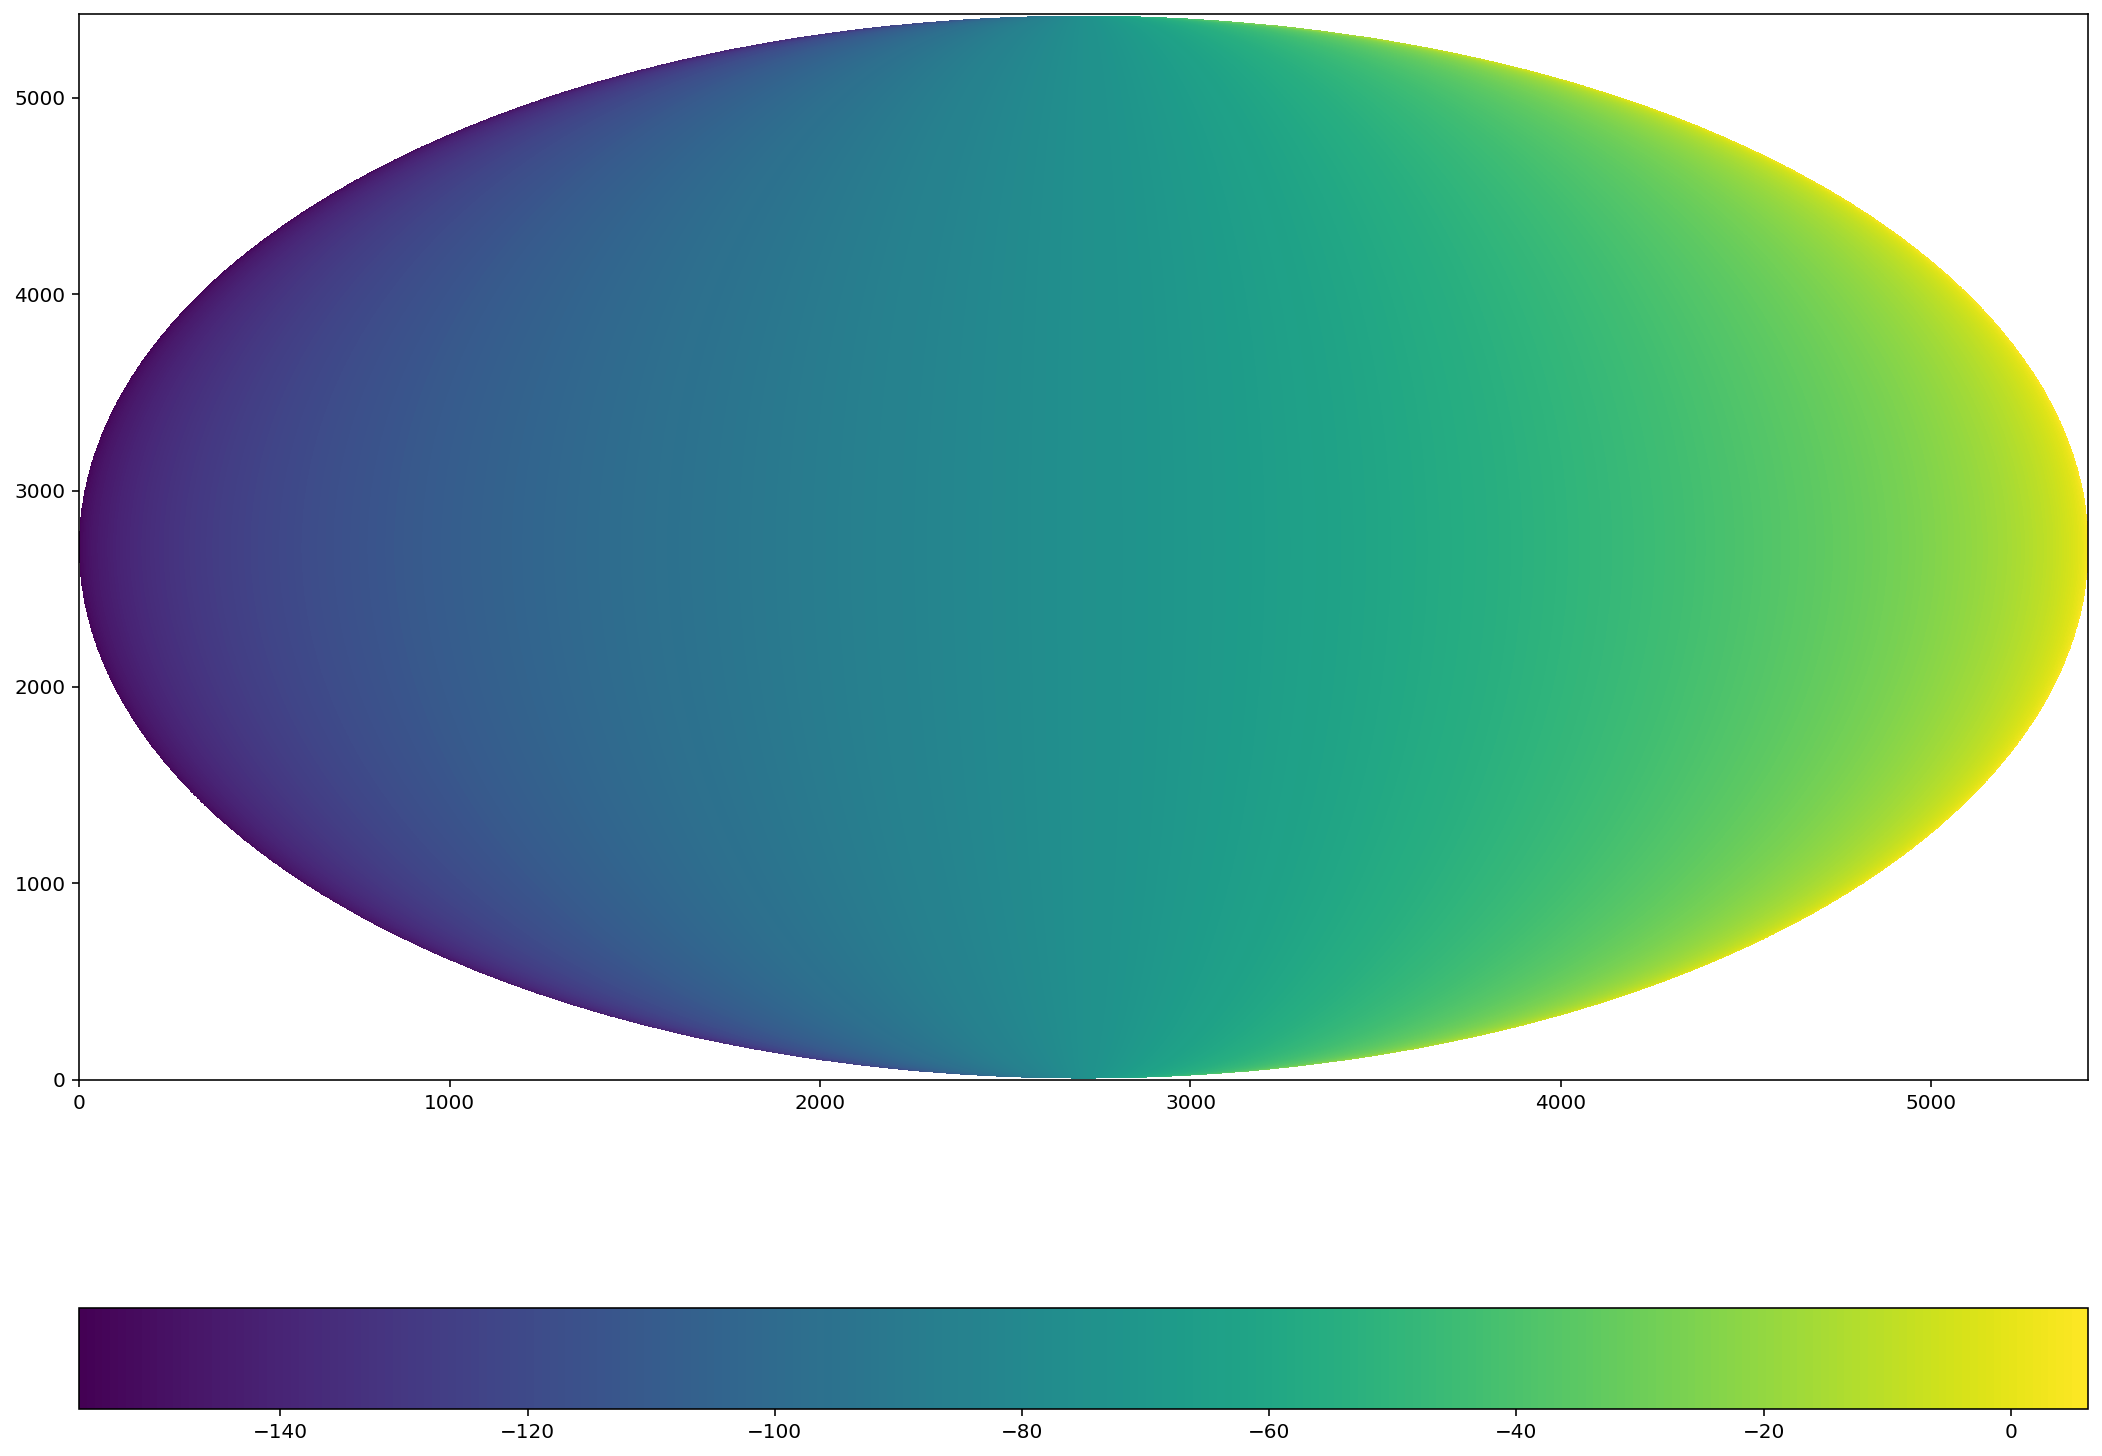

In [5]:
fig, ax1 = plt.subplots(figsize=((18,14)))
plt.pcolormesh(lon)
normalize = matplotlib.colors.Normalize(vmin=np.nanmin(lon), vmax=np.nanmax(lon))
cax, _ = matplotlib.colorbar.make_axes(ax1, orientation="horizontal") #,pad=0.15)
cbar = matplotlib.colorbar.ColorbarBase(cax, norm=normalize,orientation="horizontal")
#plt.pcolormesh([ds.coords['x'], ds.coords['y']])
print(np.nanmin(lon), np.nanmax(lon))
print(np.nanmin(lat), np.nanmax(lat))

In [18]:
#Determine index from radian range (above)
lon_bnds_min = np.nanmin(np.where(ds_subset.coords['x']>=0))
lon_bnds_max = np.nanmin(np.where(ds_subset.coords['x']>=0.021))
lat_bnds_min = np.nanmax(np.where(ds_subset.coords['y']>=0.110)) #nanmax as highest lats are at lowest y indices
lat_bnds_max = np.nanmax(np.where(ds_subset.coords['y']>=0.090))

##Determine index from a desired lat and lon range
##This works BUT comes up with a much wider range of indices than req ()
#lon_bnds_min = np.where(lon>=-75)
#lon_bnds_min = np.nanmin(lon_bnds_min[1])
#lon_bnds_max = np.where(lon>=-66)
#lon_bnds_max = np.nanmax(lon_bnds_max[1])
##As highest lats lowest indices, the min bound is for the higher latitude
#lat_bnds_max = np.where(lat>=30)
#lat_bnds_max = np.nanmax(lat_bnds_max[0]) #nanmax as highest lats are at lowest y indices
#lat_bnds_min = np.where(lat>=45)
#lat_bnds_min = np.nanmin(lat_bnds_min[0])

print(lon_bnds_min, lon_bnds_max)
print(lat_bnds_min, lat_bnds_max)

2712 3087
747 1104


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-19-3760bc97840f>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  quadmesh = plt.pcolor(lon_gs, lat_gs, mean_SST, cmap=cmap, norm=normalize)


(32.0, 40.0)

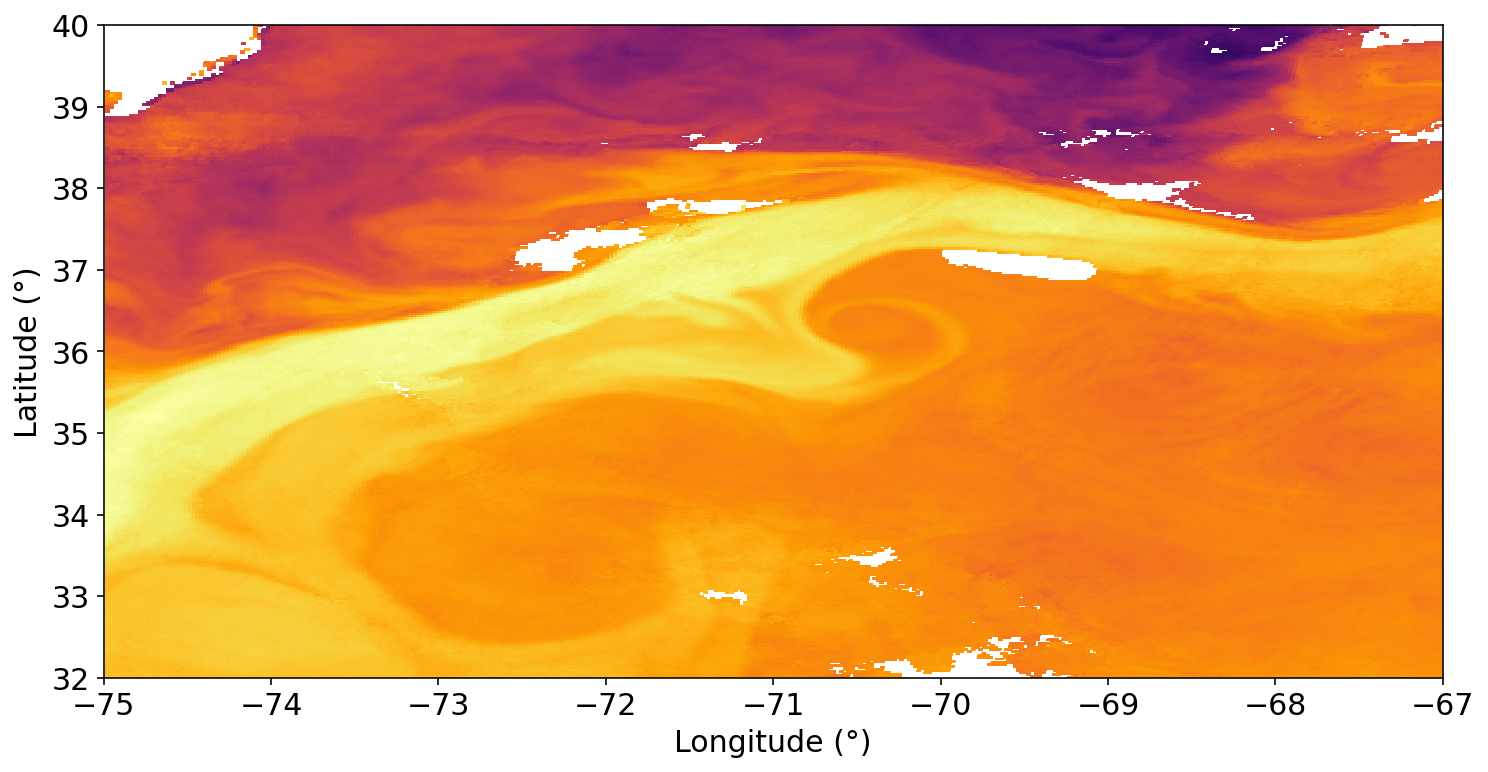

In [19]:
#Create basic plot (w/ sensible coords)
ds_subset = ds.isel(time=slice(0,24))

#gs_subset = ds_subset.sel(x=slice(0.0,0.020),y=slice(0.110,0.090))  #reduce to GS region
gs_subset = ds_subset.isel(x=slice(lon_bnds_min,lon_bnds_max),y=slice(lat_bnds_min,lat_bnds_max))
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
#mean_SST.plot(cmap='inferno')

lat_gs = lat[lat_bnds_min:lat_bnds_max, lon_bnds_min:lon_bnds_max] #in format [lat,lon]
lon_gs = lon[lat_bnds_min:lat_bnds_max, lon_bnds_min:lon_bnds_max]

matplotlib.rcParams.update({'font.size': 15})
cmap = plt.get_cmap('inferno')
normalize=matplotlib.colors.Normalize(vmin=np.nanmin(mean_SST), vmax=np.nanmax(mean_SST)) 
quadmesh = plt.pcolor(lon_gs, lat_gs, mean_SST, cmap=cmap, norm=normalize)
cax, _ = matplotlib.colorbar.make_axes(ax1, orientation="horizontal") #,pad=0.15)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,orientation="horizontal")
cbar.set_label('SST (\u00b0 C)')

plt.xlabel('Longitude (\u00b0)')
plt.ylabel('Latitude (\u00b0)')
#Need to subset as otherwise have regions incl in lat/lon range but where SST is not plotted
plt.xlim([-75,-67])
plt.ylim([32,40])

#plt.show()


In [8]:
##Plot global view #not yet functional
gs_subset = ds_subset
masked = gs_subset.SST.where(gs_subset.DQF==0)
mean_SST = masked.mean('time') 
#mean_SST.plot(cmap='inferno')

#fig, ax1 = plt.subplots(figsize=((18,14)))
#ax1 = plt.subplot(projection=ccrs.Mollweide())
#ax1.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax1.add_feature(cartopy.feature.LAND)
#gl = ax1.gridlines(draw_labels=False)
#plt.pcolormesh(lat, lon, mean_SST, cmap='inferno') #gives error as corners have nans
#plt.show()